In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

Graph with 12 nodes and 17 edges


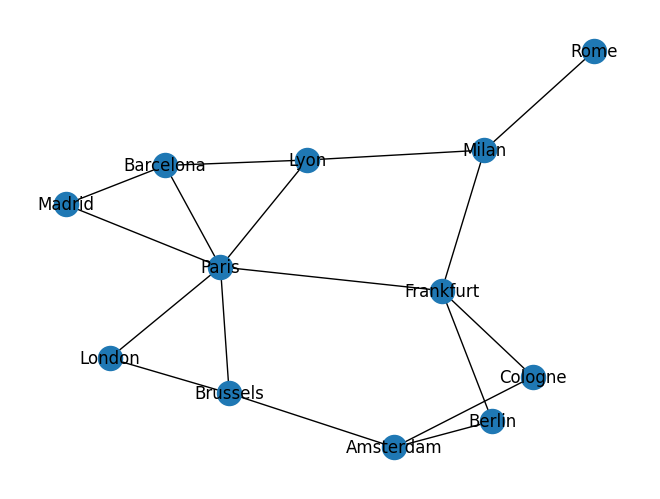

In [2]:
graph = nx.Graph()

graph.add_nodes_from(["London", "Paris", "Madrid", "Barcelona", "Lyon", "Milan", "Rome", "Frankfurt", "Cologne", "Berlin", "Brussels", "Amsterdam"])
# London
graph.add_edge("London", "Paris", time=136, cost=98)
graph.add_edge("London", "Brussels", time=136, cost=98)
# Paris
graph.add_edge("Paris", "Madrid", time=225, cost=380)
graph.add_edge("Paris", "Barcelona", time=390, cost=400)
graph.add_edge("Paris", "Lyon", time=112, cost=185)
graph.add_edge("Paris", "Frankfurt", time=480, cost=345)
graph.add_edge("Paris", "Brussels", time=82, cost=80)
# Madrid
graph.add_edge("Madrid", "Barcelona", time=150, cost=98)
# Barcelona
graph.add_edge("Barcelona", "Lyon", time=200, cost=320)
# Lyon
graph.add_edge("Lyon", "Milan", time=176, cost=180)
# Milan
graph.add_edge("Milan", "Rome", time=168, cost=125)
graph.add_edge("Milan", "Frankfurt", time=454, cost=240)
# Frankfurt
graph.add_edge("Frankfurt", "Cologne", time=120, cost=40)
graph.add_edge("Frankfurt", "Berlin", time=232, cost=125)
# Brussels
graph.add_edge("Brussels", "Amsterdam", time=105, cost=48)

# Amsterdam
graph.add_edge("Amsterdam", "Berlin", time=364, cost=235)
graph.add_edge("Amsterdam", "Cologne", time=120, cost=40)

print(graph)
nx.draw(graph, with_labels=True)
plt.show()


In [3]:
#Define the population size and number of generations
population_size = 1000
num_generations = 100

In [4]:
#Initialize Individual
def initialize_individual():
    individual = [random.choice(list(graph.nodes()))]
    total_time = 0
    while total_time <= 4320:
        current_city = individual[-1]
        valid_neighbors = [neighbor for neighbor in graph.neighbors(current_city)]
        next_city = random.choice(valid_neighbors)
        edge = (current_city, next_city)
        edge_time = graph.get_edge_data(*edge)['time']
        if total_time + edge_time <= 4320:
            individual.append(next_city)
            total_time += edge_time
        else:
            break
    return individual

In [5]:
#Fitness function
def fitness(individual):
    time = 0
    cost = 0
    for i in range(len(individual)):
        if i == len(individual)-1:
            edge = (individual[i], individual[0])
        else:
            edge = (individual[i], individual[i+1])
        if not graph.has_edge(*edge):
            return 0.0
        time += graph.get_edge_data(edge[0], edge[1])['time']
        cost += graph.get_edge_data(edge[0], edge[1])['cost']
    
    time_diff = abs(4320 - time)
    time_reward = 1 - (time_diff / 4320)
    
    time_penalty = 0
    if time > 4320:
        time_penalty = 1 * time_diff / 4320
    
    return time_reward / (cost + 1) - time_penalty


In [6]:
#Selection
def tournament_selection(population, k):
    best_individual = None
    for _ in range(k):
        individual = random.choice(population)
        if best_individual is None or fitness(individual) > fitness(best_individual):
            best_individual = individual
    return best_individual


In [7]:
#Crossover function
def crossover(parent1, parent2):
    if parent1 == parent2:
        return parent1, parent2
    size1, size2 = len(parent1), len(parent2)
    child1, child2 = [None] * size1, [None] * size2
    start1, end1 = sorted([random.randrange(size1) for _ in range(2)])
    child1[start1:end1] = parent1[start1:end1]
    count1 = 0
    for city in parent2:
        if city not in child1[start1:end1]:
            if count1 == start1:
                count1 = end1
            if count1 >= size1:
                break
            child1[count1] = city
            count1 += 1
    start2, end2 = sorted([random.randrange(size2) for _ in range(2)])
    child2[start2:end2] = parent2[start2:end2]
    count2 = 0
    for city in parent1:
        if city not in child2[start2:end2]:
            if count2 == start2:
                count2 = end2
            if count2 >= size2:
                break
            child2[count2] = city
            count2 += 1

    return child1, child2

In [8]:
#Mutation
def mutate(individual):
    mutated_individual = individual.copy()
    i = random.randint(0, len(mutated_individual) - 1)
    j = random.randint(0, len(mutated_individual) - 1)

    mutated_individual[i], mutated_individual[j] = mutated_individual[j], mutated_individual[i]

    return mutated_individual

In [9]:
population = [initialize_individual() for i in range(population_size)]

#Start genetic algorithm
for generation in range(num_generations):

    best_fitness = max(fitness(ind) for ind in population)
    avg_fitness = sum(fitness(ind) for ind in population) / population_size
    worst_fitness = min(fitness(ind) for ind in population)
    print(f"Generation {generation + 1}: Best fitness = {best_fitness:.8f}, Average fitness = {avg_fitness:.8f}, Worst fitness = {worst_fitness:.8f}")

    parent1 = tournament_selection(population, k=6)
    population.remove(parent1)
    parent2 = tournament_selection(population, k=6)
    population.remove(parent2)
    
    child1, child2 = crossover(parent1, parent2)
    child1 = mutate(child1)
    child2 = mutate(child2)
    
    population.extend([child1, child2])
    
    worst_individual = min(population, key=fitness)
    population.remove(worst_individual)
    new_individual = list(graph.nodes())
    random.shuffle(new_individual)
    population.append(new_individual)

best_individual = max(population, key=fitness)
best_path = [(best_individual[i], best_individual[i+1]) for i in range(len(best_individual)-1) if graph.has_edge(best_individual[i], best_individual[i+1])]
best_time = sum(graph.get_edge_data(path[0], path[1])['time'] for path in best_path)
best_cost = sum(graph.get_edge_data(path[0], path[1])['cost'] for path in best_path)

complete_path = []
for city in best_individual:
    if not complete_path:
        complete_path.append(city)
    else:
        edge = (complete_path[-1], city)
        if graph.has_edge(*edge):
            complete_path.append(city)

#print("Best path:", complete_path)

formatted_path = ""
for i, city in enumerate(complete_path):
    if i == len(complete_path) - 1:
        formatted_path += city
    else:
        formatted_path += city + " -> "
    if (i+1) % 9 == 0: 
        formatted_path += "\n"

print("Best path:")
print(formatted_path)

print("Total time:", best_time)
print("Total cost:", best_cost)


Generation 1: Best fitness = 0.00047014, Average fitness = -0.00821583, Worst fitness = -0.11016075
Generation 2: Best fitness = 0.00047014, Average fitness = -0.00810644, Worst fitness = -0.10854326
Generation 3: Best fitness = 0.00047014, Average fitness = -0.00799820, Worst fitness = -0.10838965
Generation 4: Best fitness = 0.00047014, Average fitness = -0.00789015, Worst fitness = -0.10779494
Generation 5: Best fitness = 0.00047014, Average fitness = -0.00778271, Worst fitness = -0.10717325
Generation 6: Best fitness = 0.00047014, Average fitness = -0.00767574, Worst fitness = -0.10512640
Generation 7: Best fitness = 0.00047014, Average fitness = -0.00757097, Worst fitness = -0.10038110
Generation 8: Best fitness = 0.00047014, Average fitness = -0.00747059, Worst fitness = -0.09969625
Generation 9: Best fitness = 0.00047014, Average fitness = -0.00737111, Worst fitness = -0.09908752
Generation 10: Best fitness = 0.00047014, Average fitness = -0.00727242, Worst fitness = -0.09879965